In [184]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator, EMAIndicator
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [185]:
data = pd.read_csv('.\data1mins.csv')

In [186]:
data

Loading ITables v2.5.2 from the internet... (need help?)


In [187]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [188]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [189]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2098, 10, 16),
 datetime.date(2259, 8, 18),
 datetime.date(2113, 8, 17),
 datetime.date(2032, 6, 17),
 datetime.date(2132, 7, 17),
 datetime.date(2071, 2, 19),
 datetime.date(2245, 1, 16),
 datetime.date(2192, 8, 16),
 datetime.date(2089, 12, 15),
 datetime.date(2137, 3, 21),
 datetime.date(2193, 4, 18),
 datetime.date(2134, 9, 16),
 datetime.date(2102, 2, 16),
 datetime.date(2019, 11, 21),
 datetime.date(2116, 5, 21),
 datetime.date(2037, 4, 16),
 datetime.date(2214, 1, 20),
 datetime.date(2222, 9, 19),
 datetime.date(2057, 5, 17),
 datetime.date(2249, 11, 15),
 datetime.date(2100, 5, 20),
 datetime.date(2147, 6, 15),
 datetime.date(2213, 7, 15),
 datetime.date(2242, 3, 17),
 datetime.date(2073, 8, 17),
 datetime.date(2105, 2, 19),
 datetime.date(2162, 3, 18),
 datetime.date(2067, 3, 17),
 datetime.date(2017, 1, 19),
 datetime.date(2100, 4, 15),
 datetime.date(2204, 11, 15),
 datetime.date(2240, 11, 19),
 datetime.date(2216, 7, 18),
 datetime.date(2075, 4, 18),
 datetim

In [190]:
def alpha(data, params):
    # Giả sử data có cột 'Close', 'Date' (datetime index hoặc column)
    # Params: t1 (lowpass period), w1 (RSI window), w2 (poly window), t2 (RSI enter long, thấp hơn để dễ vào? - theo code dùng t2),
    # t3 (RSI exit long, thấp hơn để khó thoát? - theo code dùng t3 cho exit), t4 (slope threshold >0), t5 (curvature threshold >0? - theo code dùng t5 cho curvature)
    # Thêm: consec_increases (số phiên liên tiếp tăng để xác nhận entry, default 2)
   
    data = data.copy() # Tránh modify original
    data['Close_filtered'] = lowpass_filter_period_only(data['Close'], params['t1']) # Giữ nguyên lọc
    # Tính RSI (giữ nguyên)
    data['RSI'] = RSIIndicator(close=data['Close'], window=params['w1']).rsi()
   
    # Khởi tạo
    pos = 0
    position = []
    poly_window = params.get('w2') # Window cho poly fit, default 20

   
    for i in range(len(data)):
        # Lấy RSI hiện tại
        RSI = data['RSI'].iloc[i] # Sửa .values[i] thành .iloc[i] cho an toàn
       
        # Tính poly fit trên window gần nhất (Close prices)
        if i >= poly_window - 1:
            # Lấy slice Close từ i - poly_window +1 đến i
            y = data['Close'].iloc[i - poly_window + 1 : i + 1].values
            x = np.arange(len(y)) # x = 0,1,2,... cho fit đơn giản
            # Fit bậc 2: poly = ax^2 + bx + c → coeffs = [a, b, c]
            coeffs = np.polyfit(x, y, 2)
            curvature = coeffs[0] # Hệ số bậc 2 (độ cong)
            slope = coeffs[1] # Hệ số bậc 1 (độ dốc)
            
            # Fit bậc 1: poly = ax + b -> coeffs = [a, b]
            coeffs_1 = np.polyfit(x, y, 1)
            slope_1 = coeffs_1[0]
            
        else:
            # Nếu i < window, dùng full data đến i (hoặc skip, nhưng để đơn giản)
            y = data['Close'].iloc[:i+1].values
            x = np.arange(len(y))
            if len(y) >= 2:
                coeffs = np.polyfit(x, y, 2)
                curvature = coeffs[0]
                slope = coeffs[1]
                
                coeffs_1 = np.polyfit(x, y, 1)
                slope_1 = coeffs_1[0]
            else:
                slope = 0
                curvature = 0
       
       
        # Logic vị thế Short-only
        if pos == 0:
            # Điều kiện vào short: RSI > t2 (dễ hơn) VÀ slope > t4 (xác nhận tăng) VÀ entry_confirmed (vài phiên tăng liên tiếp)
            if RSI < params['t2']:
                pos = -1
        else: # pos == -1
            if RSI > params['t3']:
                pos = 0
       
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0
       
        position.append(pos)
   
    # Gán cột pos
    data['pos'] = position
    return data

In [191]:
params = {'t1': 0.75, 't2': 30, 't3': 35, 't4': 0, 't5': 0, 'w1': 14, 'w2': 10}

In [192]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 6.12
MDD: 148.8 (9.63%)

   Total trading quantity: 593
         Profit per trade: 0.95
             Total Profit: 797.7
         Profit after fee: 564.2
 Trading quantity per day: 0.31
 Profit per day after fee: 0.3
                   Return: 0.05
          Profit per year: 74.05
                  HitRate: 0.36
          HitRate per day: 0.14


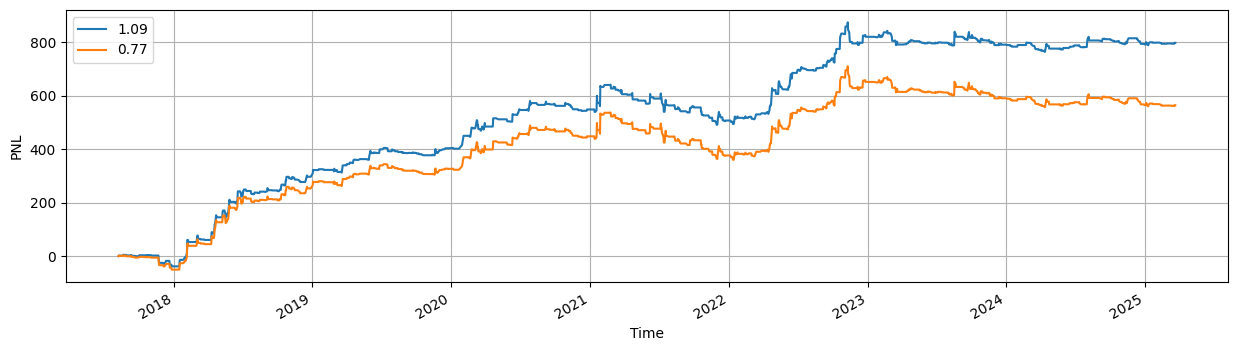

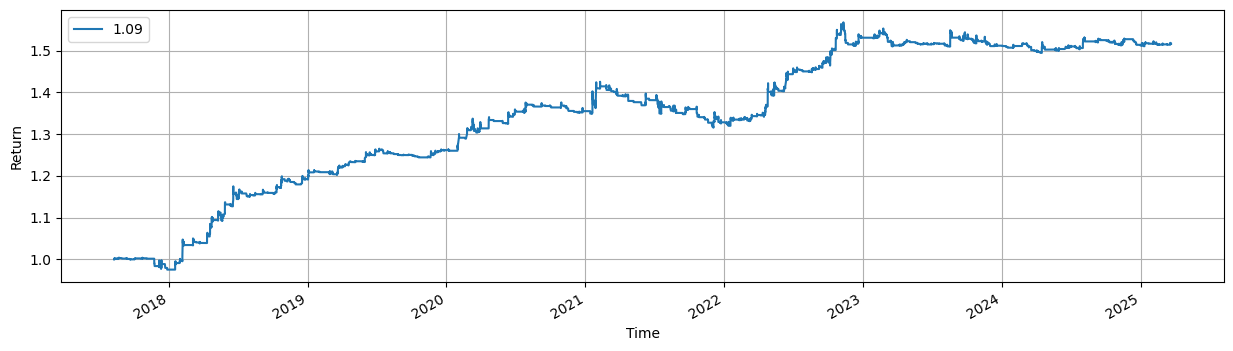

In [193]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [194]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [195]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)


In [196]:
merged = pd.merge(ds, pnl, left_on="Date",right_on= "Datetime", how="inner")
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [197]:
df = pd.DataFrame(ds)

# select Date and pos
df_result = df[["Date", "Close", "pos"]]
df_result.to_csv("alpha_short_rsi.csv", index=False)